In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from fastai.tabular import add_datepart
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
from sklearn import neighbors
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
microsoft_dataset = "../dataset/EOD-MSFT.csv"
tata_dataset = "../dataset/NSE-TATAGLOBAL11.csv"
haineken_dataset = "../dataset/EURONEXT-HEIA.csv"

In [4]:
scaler = MinMaxScaler(feature_range=(0, 1))

In [5]:
df = pd.read_csv(microsoft_dataset)
df.head()

,Date,Open,High,Low,Close,Volume,Dividend,Split,Adj_Open,Adj_High,Adj_Low,Adj_Close,Adj_Volume
0,2017-12-28,85.90,85.9300,85.550,85.72,10594344.0,0.0,1.0,83.768909,83.798164,83.427592,83.593374,10594344.0
1,2017-12-27,85.65,85.9800,85.215,85.71,14678025.0,0.0,1.0,83.525111,83.846924,83.100903,83.583622,14678025.0
2,2017-12-26,85.31,85.5346,85.030,85.40,9891237.0,0.0,1.0,83.193546,83.412574,82.920492,83.281313,9891237.0
3,2017-12-22,85.40,85.6300,84.920,85.51,14145841.0,0.0,1.0,83.281313,83.505607,82.813221,83.388584,14145841.0
4,2017-12-21,86.05,86.1000,85.400,85.50,17990745.0,0.0,1.0,83.915187,83.963947,83.281313,83.378832,17990745.0


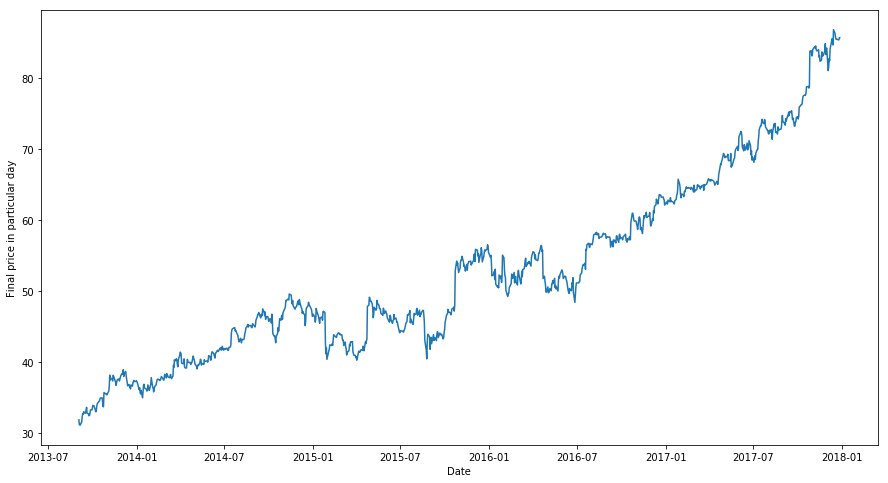

In [6]:
df["Date"] = pd.to_datetime(df.Date, format="%Y-%m-%d")
df.index = df["Date"]

plt.figure(figsize=(15, 8))
plt.plot(df["Close"])
plt.xlabel("Date")
plt.ylabel("Final price in particular day")
plt.show()

#### Moving avarage prediction

In [7]:
def process_dataframe(df):
    data = df.sort_index(ascending=True, axis=0)
    processed_data = pd.DataFrame(index=range(0, len(df)), columns=["Date", "Close"])
    
    for i in range(0, len(data)):
        processed_data["Date"][i] = data["Date"][i]
        processed_data["Close"][i] = data["Close"][i]
    
    return processed_data


def plot_predictions(train_data, test_data, predictions):
    test_data.loc[:, "Predictions"] = predictions
    plt.figure(figsize=(15, 8))
    plt.plot(train_data['Close'])
    plt.plot(test_data[['Close','Predictions']])
    plt.xlabel("Date")
    plt.ylabel("Final price in particular day")
    plt.show()

In [8]:
lr_data = process_dataframe(df)

In [9]:
train_data, test_data = train_test_split(lr_data, test_size=0.2, shuffle=False)

In [10]:
def moving_avg(train_data, test_len):
    predictions = []
    train_len = train_data.shape[0]
    for i in range(0, test_len):
        a = train_data["Close"][train_len-test_len+i:].sum() + sum(predictions)
        b = a / test_len
        predictions.append(b)
    return predictions

In [11]:
mv_avg_predictions = moving_avg(train_data, test_data.shape[0])
r_mean_square = np.sqrt(np.mean(np.power((np.array(test_data["Close"] - mv_avg_predictions)), 2)))

In [12]:
r_mean_square

15.183666454508193

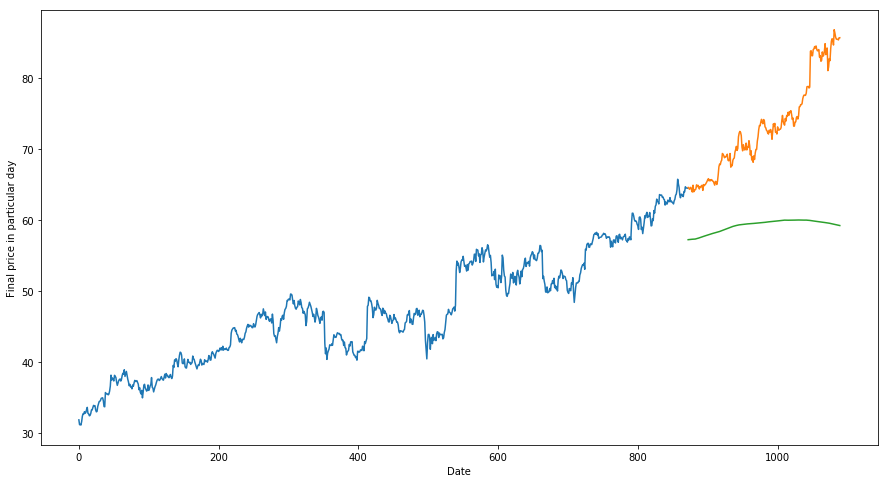

In [13]:
plot_predictions(train_data, test_data, mv_avg_predictions)

Moving avarage apporach is easy to implement, but in stock marker spectrium predicted data is not looking reaslistic at all.
I will skip linear regresion approach. There is a high change that model will overfit to the date and month column, the model will probably consider the value from the same date a month ago, or the same date/month a year ago.

#### KNN -> k-nearest neighbours
Based on independet variables find similarity between new data and old data.
I will use preimplemented KNN from sklearn library.

In [14]:
df['Date'] = pd.to_datetime(df.Date,format='%Y-%m-%d')
df.index = df['Date']

knn_data = process_dataframe(df)

In [15]:
add_datepart(knn_data, "Date")
knn_data.drop("Elapsed", axis=1, inplace=True)

In [16]:
train_data, test_data = train_test_split(knn_data, test_size=0.2, shuffle=False)

In [17]:
x_train_scaled = scaler.fit_transform(train_data.drop('Close', axis=1))
x_test_scaled = scaler.fit_transform(test_data.drop('Close', axis=1))
x_train = pd.DataFrame(x_train_scaled)
x_test = pd.DataFrame(x_test_scaled)
y_train = train_data['Close']
y_test = test_data['Close']

In [18]:
parameters = {'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9]}
knn = neighbors.KNeighborsRegressor()
model = GridSearchCV(knn, parameters, cv=5)

In [19]:
model.fit(x_train, y_train)
predictions = model.predict(x_test)

In [20]:
r_mean_square = np.sqrt(np.mean(np.power((np.array(y_test) - np.array(predictions)), 2)))

In [21]:
r_mean_square

34.54203483310681

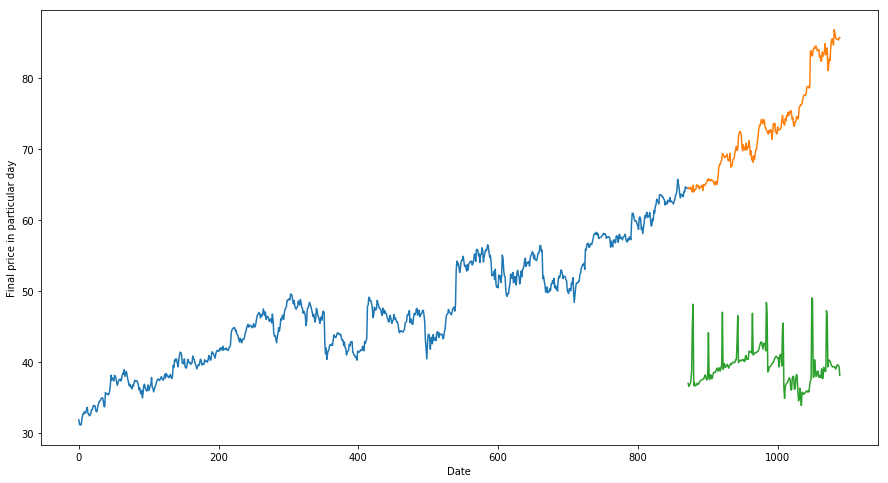

In [22]:
plot_predictions(train_data, test_data, predictions)

KNN prediction is not accurate as we can see ://

#### LSTM - Long Short Term Memory
LSTM is artificial recurrent neural network (RNN) architecture used in the field of deep learning. 
LSTM networks are well-suited to classifying, processing and making predictions based on time series data, since there can be lags of unknown duration between important events in a time series.
A common LSTM unit is composed of a cell, an input gate, an output gate and a forget gate. The cell remembers values over arbitrary time intervals and the three gates regulate the flow of information into and out of the cell.

In [67]:
lstm_data = process_dataframe(df)

lstm_data.index = lstm_data.Date
lstm_data.drop('Date', axis=1, inplace=True)

In [68]:
train_data, test_data =train_test_split(lstm_data, test_size=0.2, shuffle=False)
scaled_data = scaler.fit_transform(lstm_data)

In [69]:
x_train, y_train = [], []
for i in range(60, len(train_data)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

In [70]:
class LSTMNet:
    @staticmethod
    def build(height: int):
        input_shape = (height, 1)
        
        model = Sequential()
        model.add(LSTM(50, return_sequences=True, input_shape=input_shape))
        model.add(LSTM(50))
        model.add(Dense(1))
        
        return model

In [71]:
height = x_train.shape[1]
model = LSTMNet.build(height)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 60, 50)            10400     
_________________________________________________________________
lstm_14 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 51        
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


In [72]:
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)

Epoch 1/1
 - 86s - loss: 0.0018 - acc: 0.0000e+00


In [73]:
inputs = lstm_data[len(lstm_data) - len(test_data) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

X_test = []
for i in range(60, inputs.shape[0]):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

In [74]:
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

In [75]:
r_mean_square=np.sqrt(np.mean(np.power((test_data - predictions), 2)))

In [76]:
r_mean_square

Close    1.47423
dtype: float64

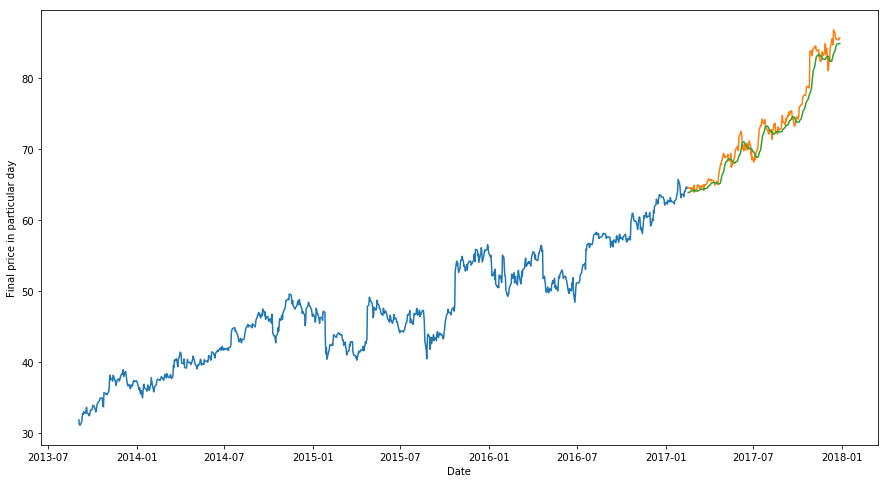

In [77]:
plot_predictions(train_data, test_data, predictions)